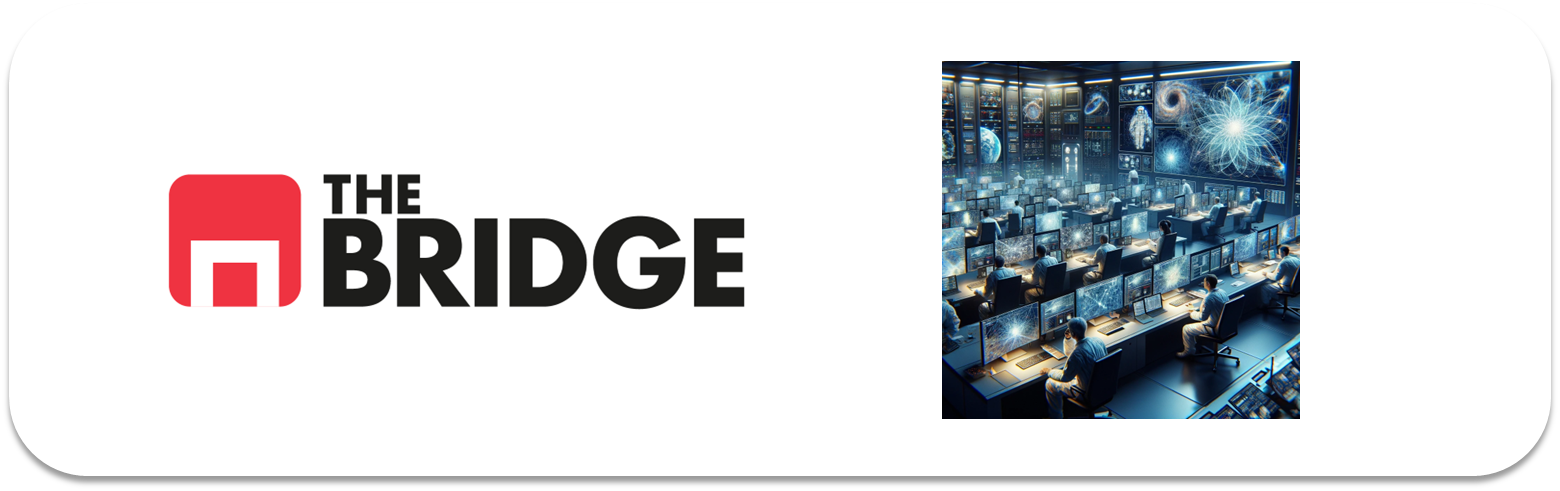

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
import os
from PIL import Image
import zipfile

from skimage.io import imread

# sklearn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle

# keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# permite cargar, preprocesar y aumentar las imágenes.
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Funciones auxiliares

def load_images(folder, reshape_dim = (32,32)):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        img = img.resize(reshape_dim)
        
        if img is not None:
            images.append(np.array(img))
            labels.append(int('dog' in filename))  # 0 = cat, 1 = dog (True for dog and False for cat)
            
    return np.array(images), np.array(labels)

def show_instances(imgs, labels):
    class_names = ['Cat', 'Dog']
    n_rows = (len(imgs) + 4) // 5
    plt.figure(figsize = (8, n_rows * 1.75))
    
    for i in range(len(imgs)):
        plt.subplot(n_rows, 5, i + 1)
        plt.title(class_names[labels[i]])
        plt.imshow(imgs[i], cmap = plt.cm.binary)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

In [3]:
# Paths train y test
train_dir = os.path.join(os.getcwd(), 'data')
test_dir = os.path.join(train_dir, 'github_test')

# Cargar y concatenar train
X_train_0, y_train_0 = load_images(os.path.join(train_dir, 'github_train_0'))
X_train_1, y_train_1 = load_images(os.path.join(train_dir, 'github_train_1'))
X_train_2, y_train_2 = load_images(os.path.join(train_dir, 'github_train_2'))
X_train_3, y_train_3 = load_images(os.path.join(train_dir, 'github_train_3'))

X_train = np.concatenate((X_train_0, X_train_1, X_train_2, X_train_3), axis = 0)
y_train = np.concatenate((y_train_0, y_train_1, y_train_2, y_train_3), axis = 0)

# Cargar test
X_test, y_test = load_images(test_dir)

In [4]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape, end = '\n\n')
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (4000, 32, 32, 3)
y_train: (4000,)

X_test: (1000, 32, 32, 3)
y_test: (1000,)


2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

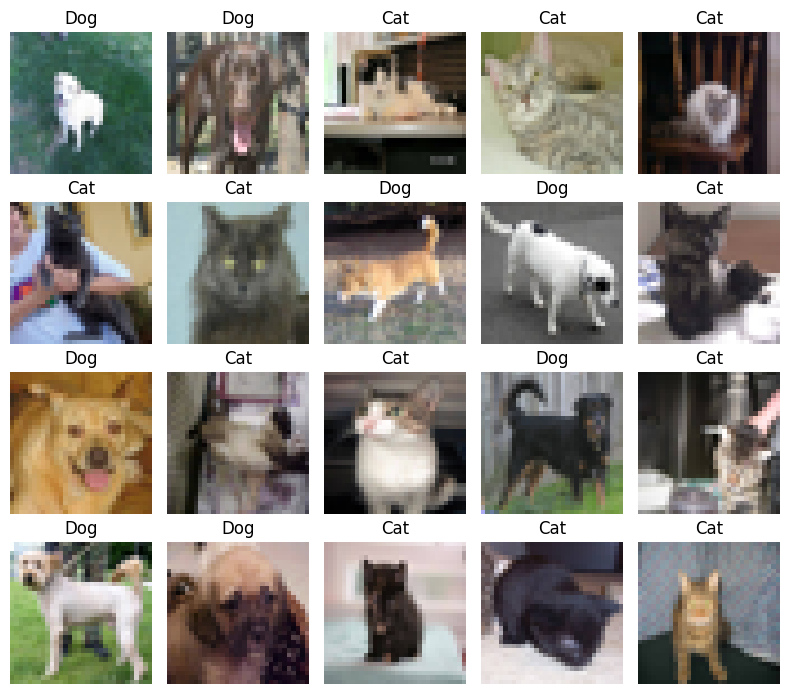

In [5]:
# Visualización imágenes

i = np.random.randint(0, len(X_train), 20)
show_instances(X_train[i], y_train[i])

In [6]:
target = pd.Series(y_train)
target.value_counts(True)

0    0.5
1    0.5
Name: proportion, dtype: float64

In [7]:
X_train[0].shape

(32, 32, 3)

In [8]:
# Normalización
X_train = X_train / 255
X_test = X_test / 255

# Shuffle (Para aumentar la aleatoriedad de los datos)
X_train, y_train = shuffle(X_train, y_train) 

In [9]:
print('X_train.shape:', X_train.shape)
print('X_train.size:', X_train.size) # Por tamaño, uso adam como optimizador

X_train.shape: (4000, 32, 32, 3)
X_train.size: 12288000


In [10]:
layers = [
    Conv2D(filters=64, kernel_size=(3,3),
                        padding='same',
                        activation='relu',
                        input_shape = X_train[0].shape),

    MaxPooling2D(pool_size=(2,2)),

    Dropout(rate=0.25),
    
    Conv2D(filters=32, kernel_size=(3,3),
                        padding='same',
                        activation='relu'),

    MaxPooling2D(pool_size=(2,2)),

    Dropout(rate=0.25),

    Conv2D(filters=16, kernel_size=(3,3),
                        padding='same',
                        activation='relu'),

    MaxPooling2D(pool_size=(2,2)),

    Dropout(rate=0.25),

    Flatten(),

    Dense(units=150, activation='relu'),

    Dropout(rate=0.25),

    Dense(units=75, activation='relu'),

    Dense(2, activation='softmax')
]

model = Sequential(layers)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        38,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,907 (292.61 KB)

 Trainable params: 74,907 (292.61 KB)

 Non-trainable params: 0 (0.00 B)

### 3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

In [11]:
# Definir callback de EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', 
                               patience = 5, 
                               restore_best_weights = True)

# Entrenar modelo
history = model.fit(X_train, 
                    y_train, 
                    epochs = 100, 
                    batch_size = 32, 
                    validation_split = 0.2, 
                    callbacks = [early_stopping])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5011 - loss: 0.7002 - val_accuracy: 0.5350 - val_loss: 0.6925
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5060 - loss: 0.6932 - val_accuracy: 0.5650 - val_loss: 0.6887
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5325 - loss: 0.6916 - val_accuracy: 0.5275 - val_loss: 0.6919
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5491 - loss: 0.6881 - val_accuracy: 0.5075 - val_loss: 0.6913
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5522 - loss: 0.6877 - val_accuracy: 0.5337 - val_loss: 0.6878
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5626 - loss: 0.6811 - val_accuracy: 0.6100 - val_loss: 0.6601
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6066 - loss: 0.6597 - val_accuracy: 0.6112 - val_loss: 0.6602
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6084 - loss: 0.6593 - 

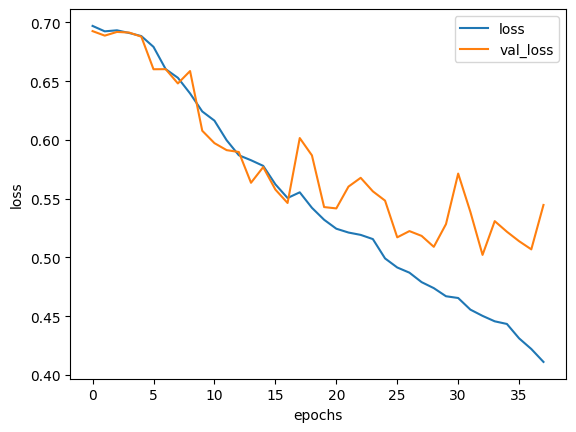

In [12]:
history_df = pd.DataFrame(history.history)
history_df[["loss","val_loss"]].plot();
plt.xlabel("epochs")
plt.ylabel("loss");

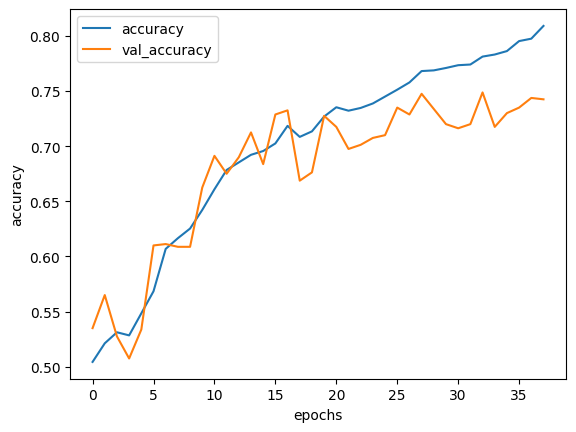

In [13]:
history_df = pd.DataFrame(history.history)
history_df[["accuracy","val_accuracy"]].plot();
plt.xlabel("epochs")
plt.ylabel("accuracy");

### 4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

In [14]:
model.evaluate(X_test,y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7716 - loss: 0.4914


[0.5015916228294373, 0.7559999823570251]

In [15]:
y_pred = [np.argmax(prediction) for prediction in  model.predict(X_test)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [16]:
print(classification_report(y_test, y_pred, target_names=["cat", "dog"]))

              precision    recall  f1-score   support

         cat       0.75      0.77      0.76       500
         dog       0.76      0.74      0.75       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



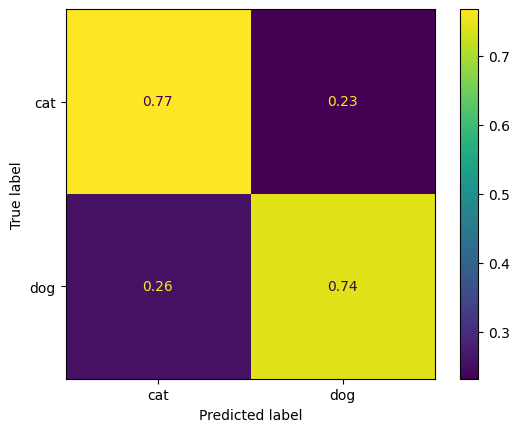

In [17]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', display_labels=["cat", "dog"])
plt.show()

### 5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perro más alta.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


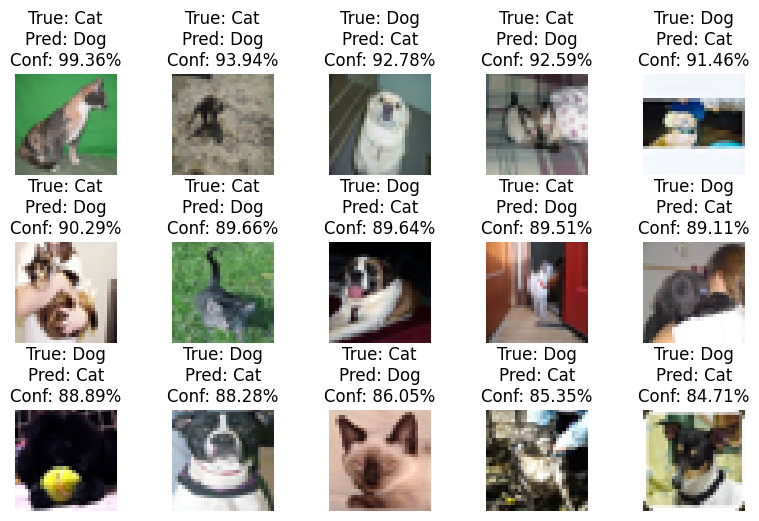

In [18]:
# Paso 1: Obtener las predicciones y las probabilidades
y_pred_prob = model.predict(X_test)  # Probabilidades de cada clase para las imágenes
y_pred = np.argmax(y_pred_prob, axis=1)  # Predicción final, tomando la clase con mayor probabilidad

# Paso 2: Identificar las mal clasificadas
incorrect_idx = np.where(y_pred != y_test)[0]

# Paso 3: Calcular la probabilidad de la clase errónea
incorrect_probs = []

for idx in incorrect_idx:
    true_class = y_test[idx]
    pred_class = y_pred[idx]
    
    # La probabilidad de la clase incorrecta será la probabilidad de la clase predicha
    incorrect_prob = y_pred_prob[idx][pred_class]
    
    incorrect_probs.append((idx, incorrect_prob))

# Paso 4: Ordenar las imágenes mal clasificadas por la probabilidad de ser de la clase incorrecta
incorrect_probs_sorted = sorted(incorrect_probs, key=lambda x: x[1], reverse=True)

# Paso 5: Seleccionar el 10% de las imágenes mal clasificadas con mayor nivel de confianza
top_10_percent = int(0.1 * len(incorrect_probs_sorted))

# Obtener los índices de las imágenes más mal clasificadas con mayor confianza
top_10_incorrect_idx = [x[0] for x in incorrect_probs_sorted[:top_10_percent]]

# Seleccionar las imágenes y etiquetas correspondientes
X_selected = X_test[top_10_incorrect_idx]
y_pred_selected = y_pred[top_10_incorrect_idx]  # Usamos la predicción errónea
y_selected = y_test[top_10_incorrect_idx]  # Etiquetas reales
confidence_selected = [x[1] for x in incorrect_probs_sorted[:top_10_percent]]  # Confianza de las imágenes

# Paso 6: Seleccionar imágenes aleatorias de las mal clasificadas
num_images_to_show = 15  # Cambiar a la cantidad que deseas mostrar
random_sample_idx = np.random.choice(top_10_incorrect_idx, size=num_images_to_show, replace=False)

# Obtener las imágenes aleatorias seleccionadas
X_random = X_test[random_sample_idx]
y_pred_random = y_pred[random_sample_idx]
y_random = y_test[random_sample_idx]
confidence_random = [x[1] for x in incorrect_probs_sorted if x[0] in random_sample_idx]

def show_instances(imgs, pred_labels, true_labels, confidences):
    class_names = ['Cat', 'Dog']
    n_rows = (len(imgs) + 4) // 5
    plt.figure(figsize=(8, n_rows * 1.75))
    
    for i in range(len(imgs)):
        plt.subplot(n_rows, 5, i + 1)
        plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}\nConf: {confidences[i]*100:.2f}%")
        plt.imshow(imgs[i], cmap=plt.cm.binary)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar las imágenes aleatorias mal clasificadas con mayor confianza
show_instances(X_random, y_pred_random, y_random, confidence_random)